[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1t0_4BxEJ0XncyYvn_VyEQhxwNMvtSUNx?usp=sharing)

In [1]:
import sys
sys.path.append('../src')

import torch
import torch.nn as nn
from copy import deepcopy
from pathlib import Path
from gsat import GSAT, ExtractorMLP
from utils import get_data_loaders, get_model, set_seed, Criterion, init_metric_dict, load_checkpoint
from trainer import run_one_epoch, update_best_epoch_res, get_viz_idx, visualize_results
from datetime import datetime


In [2]:
# dataset_name = 'ba_2motifs'
# dataset_name = 'mutag'
# model_name = 'GIN'

dataset_name = 'ogbg_molhiv'
model_name = 'PNA'

method_name = 'GSAT'
cuda_id = 0
seed = 0
set_seed(seed)

In [3]:
data_dir = Path('../data')
device = torch.device(f'cuda:{cuda_id}' if cuda_id >= 0 else 'cpu')

if model_name == 'GIN':
    model_config = {'model_name': 'GIN', 'hidden_size': 64, 'n_layers': 2, 'dropout_p': 0.3, 'use_edge_attr': True}
else:
    assert model_name == 'PNA'
    model_config = {'model_name': 'PNA', 'hidden_size': 80, 'n_layers': 4, 'dropout_p': 0.3, 'use_edge_attr': False, 
                    'atom_encoder': True, 'aggregators': ['mean', 'min', 'max', 'std'], 'scalers': False}
    
metric_dict = deepcopy(init_metric_dict)
model_dir = data_dir / dataset_name / 'logs' / (datetime.now().strftime("%m_%d_%Y-%H_%M_%S") + '-' + dataset_name + '-' + model_name + '-seed' + str(seed) + '-' + method_name)


In [4]:
loaders, test_set, x_dim, edge_attr_dim, num_class, aux_info = get_data_loaders(data_dir, dataset_name, batch_size=128, random_state=seed,
                                                                                splits={'train': 0.8, 'valid': 0.1, 'test': 0.1}, 
                                                                                mutag_x=True if dataset_name == 'mutag' else False)
model_config['deg'] = aux_info['deg']

[INFO] Using default splits!
[INFO] Calculating degree...


In [5]:
clf = get_model(x_dim, edge_attr_dim, num_class, aux_info['multi_label'], model_config, device)
extractor = ExtractorMLP(model_config['hidden_size'], learn_edge_att=False).to(device)
optimizer = torch.optim.Adam(list(extractor.parameters()) + list(clf.parameters()), lr=1e-3, weight_decay=3.0e-6)
criterion = Criterion(num_class, aux_info['multi_label'])
gsat = GSAT(clf, extractor, criterion, optimizer, learn_edge_att=False, final_r=0.7)

[INFO] Using multi_label: False


In [6]:
for epoch in range(100):
    train_res = run_one_epoch(gsat, loaders['train'], epoch, 'train', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    valid_res = run_one_epoch(gsat, loaders['valid'], epoch, 'valid', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    test_res = run_one_epoch(gsat, loaders['test'], epoch, 'test', dataset_name, seed, model_config['use_edge_attr'], aux_info['multi_label'])
    
    metric_dict = update_best_epoch_res(gsat, train_res, valid_res, test_res, metric_dict, dataset_name, epoch, model_dir)
    print(f'[Seed {seed}, Epoch: {epoch}]: Best Epoch: {metric_dict["metric/best_clf_epoch"]}, '
          f'Best Val Pred ACC/ROC: {metric_dict["metric/best_clf_valid"]:.3f}, Best Test Pred ACC/ROC: {metric_dict["metric/best_clf_test"]:.3f}, '
          f'Best Test X AUROC: {metric_dict["metric/best_x_roc_test"]:.3f}')
    print('='*50)
    print('='*50)

[Seed 0, Epoch: 0]: gsat_train finished, loss: 0.392, pred: 0.182, info: 0.209, clf_acc: 0.948, clf_roc: 0.598, att_roc: 0.000: 100%|██████████| 258/258 [00:14<00:00, 17.76it/s]
[Seed 0, Epoch: 0]: gsat_valid finished, loss: 0.147, pred: 0.098, info: 0.049, clf_acc: 0.980, clf_roc: 0.696, att_roc: 0.000: 100%|██████████| 33/33 [00:01<00:00, 29.19it/s]
[Seed 0, Epoch: 0]: gsat_test  finished, loss: 0.179, pred: 0.130, info: 0.049, clf_acc: 0.968, clf_roc: 0.710, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 36.49it/s]


[Seed 0, Epoch: 0]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 1]: gsat_train finished, loss: 0.236, pred: 0.147, info: 0.089, clf_acc: 0.963, clf_roc: 0.707, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.63it/s]
[Seed 0, Epoch: 1]: gsat_valid finished, loss: 0.168, pred: 0.097, info: 0.071, clf_acc: 0.980, clf_roc: 0.729, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.92it/s]
[Seed 0, Epoch: 1]: gsat_test  finished, loss: 0.199, pred: 0.128, info: 0.071, clf_acc: 0.968, clf_roc: 0.735, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.78it/s]


[Seed 0, Epoch: 1]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 2]: gsat_train finished, loss: 0.226, pred: 0.140, info: 0.086, clf_acc: 0.963, clf_roc: 0.744, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.98it/s]
[Seed 0, Epoch: 2]: gsat_valid finished, loss: 0.163, pred: 0.086, info: 0.077, clf_acc: 0.980, clf_roc: 0.773, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.17it/s]
[Seed 0, Epoch: 2]: gsat_test  finished, loss: 0.201, pred: 0.124, info: 0.077, clf_acc: 0.968, clf_roc: 0.725, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.36it/s]


[Seed 0, Epoch: 2]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 3]: gsat_train finished, loss: 0.223, pred: 0.138, info: 0.085, clf_acc: 0.962, clf_roc: 0.760, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.53it/s]
[Seed 0, Epoch: 3]: gsat_valid finished, loss: 0.157, pred: 0.078, info: 0.079, clf_acc: 0.982, clf_roc: 0.760, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.24it/s]
[Seed 0, Epoch: 3]: gsat_test  finished, loss: 0.202, pred: 0.124, info: 0.079, clf_acc: 0.968, clf_roc: 0.752, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.15it/s]


[Seed 0, Epoch: 3]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 4]: gsat_train finished, loss: 0.219, pred: 0.134, info: 0.085, clf_acc: 0.962, clf_roc: 0.769, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.78it/s]
[Seed 0, Epoch: 4]: gsat_valid finished, loss: 0.156, pred: 0.077, info: 0.079, clf_acc: 0.980, clf_roc: 0.777, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.07it/s]
[Seed 0, Epoch: 4]: gsat_test  finished, loss: 0.195, pred: 0.116, info: 0.079, clf_acc: 0.968, clf_roc: 0.756, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 38.85it/s]


[Seed 0, Epoch: 4]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 5]: gsat_train finished, loss: 0.217, pred: 0.132, info: 0.085, clf_acc: 0.963, clf_roc: 0.771, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.47it/s]
[Seed 0, Epoch: 5]: gsat_valid finished, loss: 0.155, pred: 0.075, info: 0.080, clf_acc: 0.981, clf_roc: 0.793, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.90it/s]
[Seed 0, Epoch: 5]: gsat_test  finished, loss: 0.198, pred: 0.118, info: 0.080, clf_acc: 0.968, clf_roc: 0.755, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.14it/s]


[Seed 0, Epoch: 5]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 6]: gsat_train finished, loss: 0.214, pred: 0.129, info: 0.085, clf_acc: 0.963, clf_roc: 0.785, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.79it/s]
[Seed 0, Epoch: 6]: gsat_valid finished, loss: 0.163, pred: 0.083, info: 0.080, clf_acc: 0.982, clf_roc: 0.788, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.35it/s]
[Seed 0, Epoch: 6]: gsat_test  finished, loss: 0.200, pred: 0.120, info: 0.080, clf_acc: 0.971, clf_roc: 0.758, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.57it/s]


[Seed 0, Epoch: 6]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 7]: gsat_train finished, loss: 0.212, pred: 0.127, info: 0.085, clf_acc: 0.963, clf_roc: 0.787, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.51it/s]
[Seed 0, Epoch: 7]: gsat_valid finished, loss: 0.159, pred: 0.079, info: 0.080, clf_acc: 0.980, clf_roc: 0.770, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.55it/s]
[Seed 0, Epoch: 7]: gsat_test  finished, loss: 0.204, pred: 0.124, info: 0.080, clf_acc: 0.968, clf_roc: 0.758, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.75it/s]


[Seed 0, Epoch: 7]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 8]: gsat_train finished, loss: 0.210, pred: 0.125, info: 0.084, clf_acc: 0.963, clf_roc: 0.794, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.66it/s]
[Seed 0, Epoch: 8]: gsat_valid finished, loss: 0.155, pred: 0.076, info: 0.080, clf_acc: 0.980, clf_roc: 0.792, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.85it/s]
[Seed 0, Epoch: 8]: gsat_test  finished, loss: 0.205, pred: 0.125, info: 0.080, clf_acc: 0.968, clf_roc: 0.756, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.28it/s]


[Seed 0, Epoch: 8]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 9]: gsat_train finished, loss: 0.209, pred: 0.125, info: 0.084, clf_acc: 0.964, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.40it/s]
[Seed 0, Epoch: 9]: gsat_valid finished, loss: 0.152, pred: 0.073, info: 0.079, clf_acc: 0.982, clf_roc: 0.790, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.70it/s]
[Seed 0, Epoch: 9]: gsat_test  finished, loss: 0.199, pred: 0.120, info: 0.079, clf_acc: 0.969, clf_roc: 0.763, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.15it/s]


[Seed 0, Epoch: 9]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 10]: gsat_train finished, loss: 0.267, pred: 0.125, info: 0.143, clf_acc: 0.964, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.12it/s]
[Seed 0, Epoch: 10]: gsat_valid finished, loss: 0.176, pred: 0.076, info: 0.099, clf_acc: 0.981, clf_roc: 0.776, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.91it/s]
[Seed 0, Epoch: 10]: gsat_test  finished, loss: 0.221, pred: 0.122, info: 0.099, clf_acc: 0.970, clf_roc: 0.770, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.27it/s]


[Seed 0, Epoch: 10]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 11]: gsat_train finished, loss: 0.263, pred: 0.125, info: 0.137, clf_acc: 0.963, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.31it/s]
[Seed 0, Epoch: 11]: gsat_valid finished, loss: 0.171, pred: 0.075, info: 0.096, clf_acc: 0.982, clf_roc: 0.782, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.04it/s]
[Seed 0, Epoch: 11]: gsat_test  finished, loss: 0.215, pred: 0.119, info: 0.095, clf_acc: 0.967, clf_roc: 0.770, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 39.67it/s]


[Seed 0, Epoch: 11]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 12]: gsat_train finished, loss: 0.261, pred: 0.124, info: 0.137, clf_acc: 0.963, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.82it/s]
[Seed 0, Epoch: 12]: gsat_valid finished, loss: 0.171, pred: 0.078, info: 0.093, clf_acc: 0.981, clf_roc: 0.776, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.73it/s]
[Seed 0, Epoch: 12]: gsat_test  finished, loss: 0.209, pred: 0.116, info: 0.093, clf_acc: 0.969, clf_roc: 0.767, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.30it/s]


[Seed 0, Epoch: 12]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 13]: gsat_train finished, loss: 0.260, pred: 0.123, info: 0.137, clf_acc: 0.964, clf_roc: 0.809, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.59it/s]
[Seed 0, Epoch: 13]: gsat_valid finished, loss: 0.180, pred: 0.081, info: 0.098, clf_acc: 0.982, clf_roc: 0.791, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.12it/s]
[Seed 0, Epoch: 13]: gsat_test  finished, loss: 0.215, pred: 0.117, info: 0.098, clf_acc: 0.971, clf_roc: 0.783, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.43it/s]


[Seed 0, Epoch: 13]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 14]: gsat_train finished, loss: 0.260, pred: 0.124, info: 0.136, clf_acc: 0.965, clf_roc: 0.813, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.80it/s]
[Seed 0, Epoch: 14]: gsat_valid finished, loss: 0.165, pred: 0.075, info: 0.090, clf_acc: 0.981, clf_roc: 0.794, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.18it/s]
[Seed 0, Epoch: 14]: gsat_test  finished, loss: 0.205, pred: 0.115, info: 0.090, clf_acc: 0.968, clf_roc: 0.788, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.79it/s]


[Seed 0, Epoch: 14]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 15]: gsat_train finished, loss: 0.258, pred: 0.122, info: 0.136, clf_acc: 0.965, clf_roc: 0.812, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.75it/s]
[Seed 0, Epoch: 15]: gsat_valid finished, loss: 0.167, pred: 0.072, info: 0.095, clf_acc: 0.982, clf_roc: 0.790, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.72it/s]
[Seed 0, Epoch: 15]: gsat_test  finished, loss: 0.212, pred: 0.116, info: 0.095, clf_acc: 0.969, clf_roc: 0.782, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.56it/s]


[Seed 0, Epoch: 15]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 16]: gsat_train finished, loss: 0.257, pred: 0.121, info: 0.136, clf_acc: 0.964, clf_roc: 0.815, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.59it/s]
[Seed 0, Epoch: 16]: gsat_valid finished, loss: 0.167, pred: 0.074, info: 0.093, clf_acc: 0.981, clf_roc: 0.768, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.56it/s]
[Seed 0, Epoch: 16]: gsat_test  finished, loss: 0.208, pred: 0.114, info: 0.093, clf_acc: 0.970, clf_roc: 0.791, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.96it/s]


[Seed 0, Epoch: 16]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 17]: gsat_train finished, loss: 0.255, pred: 0.120, info: 0.135, clf_acc: 0.966, clf_roc: 0.810, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.58it/s]
[Seed 0, Epoch: 17]: gsat_valid finished, loss: 0.169, pred: 0.073, info: 0.096, clf_acc: 0.983, clf_roc: 0.800, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 44.70it/s]
[Seed 0, Epoch: 17]: gsat_test  finished, loss: 0.214, pred: 0.118, info: 0.096, clf_acc: 0.968, clf_roc: 0.784, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.91it/s]


[Seed 0, Epoch: 17]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 18]: gsat_train finished, loss: 0.255, pred: 0.120, info: 0.135, clf_acc: 0.966, clf_roc: 0.812, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.46it/s]
[Seed 0, Epoch: 18]: gsat_valid finished, loss: 0.167, pred: 0.072, info: 0.095, clf_acc: 0.981, clf_roc: 0.808, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 38.18it/s]
[Seed 0, Epoch: 18]: gsat_test  finished, loss: 0.209, pred: 0.114, info: 0.095, clf_acc: 0.970, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.32it/s]


[Seed 0, Epoch: 18]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 19]: gsat_train finished, loss: 0.252, pred: 0.118, info: 0.135, clf_acc: 0.965, clf_roc: 0.823, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.23it/s]
[Seed 0, Epoch: 19]: gsat_valid finished, loss: 0.168, pred: 0.075, info: 0.094, clf_acc: 0.981, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.05it/s]
[Seed 0, Epoch: 19]: gsat_test  finished, loss: 0.212, pred: 0.119, info: 0.093, clf_acc: 0.968, clf_roc: 0.792, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.79it/s]


[Seed 0, Epoch: 19]: Best Epoch: 0, Best Val Pred ACC/ROC: 0.000, Best Test Pred ACC/ROC: 0.000, Best Test X AUROC: 0.000


[Seed 0, Epoch: 20]: gsat_train finished, loss: 0.292, pred: 0.123, info: 0.170, clf_acc: 0.965, clf_roc: 0.814, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.64it/s]
[Seed 0, Epoch: 20]: gsat_valid finished, loss: 0.145, pred: 0.070, info: 0.075, clf_acc: 0.981, clf_roc: 0.815, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.46it/s]
[Seed 0, Epoch: 20]: gsat_test  finished, loss: 0.187, pred: 0.112, info: 0.075, clf_acc: 0.970, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.75it/s]


[Seed 0, Epoch: 20]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 21]: gsat_train finished, loss: 0.291, pred: 0.123, info: 0.168, clf_acc: 0.965, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.46it/s]
[Seed 0, Epoch: 21]: gsat_valid finished, loss: 0.150, pred: 0.072, info: 0.078, clf_acc: 0.982, clf_roc: 0.785, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.85it/s]
[Seed 0, Epoch: 21]: gsat_test  finished, loss: 0.188, pred: 0.110, info: 0.078, clf_acc: 0.969, clf_roc: 0.797, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.46it/s]


[Seed 0, Epoch: 21]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 22]: gsat_train finished, loss: 0.293, pred: 0.125, info: 0.168, clf_acc: 0.965, clf_roc: 0.799, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.32it/s]
[Seed 0, Epoch: 22]: gsat_valid finished, loss: 0.150, pred: 0.076, info: 0.074, clf_acc: 0.979, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.17it/s]
[Seed 0, Epoch: 22]: gsat_test  finished, loss: 0.189, pred: 0.115, info: 0.074, clf_acc: 0.965, clf_roc: 0.792, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.47it/s]


[Seed 0, Epoch: 22]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 23]: gsat_train finished, loss: 0.288, pred: 0.120, info: 0.167, clf_acc: 0.966, clf_roc: 0.809, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.72it/s]
[Seed 0, Epoch: 23]: gsat_valid finished, loss: 0.148, pred: 0.080, info: 0.068, clf_acc: 0.981, clf_roc: 0.765, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.60it/s]
[Seed 0, Epoch: 23]: gsat_test  finished, loss: 0.197, pred: 0.129, info: 0.068, clf_acc: 0.969, clf_roc: 0.756, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.15it/s]


[Seed 0, Epoch: 23]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 24]: gsat_train finished, loss: 0.288, pred: 0.120, info: 0.168, clf_acc: 0.966, clf_roc: 0.814, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.57it/s]
[Seed 0, Epoch: 24]: gsat_valid finished, loss: 0.145, pred: 0.078, info: 0.067, clf_acc: 0.979, clf_roc: 0.786, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 48.57it/s]
[Seed 0, Epoch: 24]: gsat_test  finished, loss: 0.182, pred: 0.116, info: 0.067, clf_acc: 0.965, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.43it/s]


[Seed 0, Epoch: 24]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 25]: gsat_train finished, loss: 0.288, pred: 0.120, info: 0.168, clf_acc: 0.965, clf_roc: 0.818, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.36it/s]
[Seed 0, Epoch: 25]: gsat_valid finished, loss: 0.142, pred: 0.079, info: 0.062, clf_acc: 0.981, clf_roc: 0.777, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.20it/s]
[Seed 0, Epoch: 25]: gsat_test  finished, loss: 0.176, pred: 0.114, info: 0.062, clf_acc: 0.969, clf_roc: 0.783, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.31it/s]


[Seed 0, Epoch: 25]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 26]: gsat_train finished, loss: 0.286, pred: 0.119, info: 0.167, clf_acc: 0.966, clf_roc: 0.821, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.83it/s]
[Seed 0, Epoch: 26]: gsat_valid finished, loss: 0.146, pred: 0.073, info: 0.074, clf_acc: 0.982, clf_roc: 0.785, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 48.71it/s]
[Seed 0, Epoch: 26]: gsat_test  finished, loss: 0.188, pred: 0.114, info: 0.074, clf_acc: 0.970, clf_roc: 0.786, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.55it/s]


[Seed 0, Epoch: 26]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 27]: gsat_train finished, loss: 0.286, pred: 0.118, info: 0.168, clf_acc: 0.966, clf_roc: 0.824, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.65it/s]
[Seed 0, Epoch: 27]: gsat_valid finished, loss: 0.159, pred: 0.082, info: 0.077, clf_acc: 0.977, clf_roc: 0.775, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.91it/s]
[Seed 0, Epoch: 27]: gsat_test  finished, loss: 0.196, pred: 0.119, info: 0.077, clf_acc: 0.963, clf_roc: 0.797, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.93it/s]


[Seed 0, Epoch: 27]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 28]: gsat_train finished, loss: 0.285, pred: 0.117, info: 0.168, clf_acc: 0.966, clf_roc: 0.824, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.72it/s]
[Seed 0, Epoch: 28]: gsat_valid finished, loss: 0.162, pred: 0.093, info: 0.068, clf_acc: 0.974, clf_roc: 0.782, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.73it/s]
[Seed 0, Epoch: 28]: gsat_test  finished, loss: 0.196, pred: 0.127, info: 0.068, clf_acc: 0.960, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.21it/s]


[Seed 0, Epoch: 28]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 29]: gsat_train finished, loss: 0.285, pred: 0.118, info: 0.168, clf_acc: 0.966, clf_roc: 0.821, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.71it/s]
[Seed 0, Epoch: 29]: gsat_valid finished, loss: 0.145, pred: 0.073, info: 0.072, clf_acc: 0.981, clf_roc: 0.814, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.23it/s]
[Seed 0, Epoch: 29]: gsat_test  finished, loss: 0.188, pred: 0.116, info: 0.072, clf_acc: 0.965, clf_roc: 0.802, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.54it/s]


[Seed 0, Epoch: 29]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 30]: gsat_train finished, loss: 0.284, pred: 0.117, info: 0.168, clf_acc: 0.966, clf_roc: 0.829, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.72it/s]
[Seed 0, Epoch: 30]: gsat_valid finished, loss: 0.140, pred: 0.072, info: 0.069, clf_acc: 0.983, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.93it/s]
[Seed 0, Epoch: 30]: gsat_test  finished, loss: 0.178, pred: 0.109, info: 0.069, clf_acc: 0.970, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.42it/s]


[Seed 0, Epoch: 30]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 31]: gsat_train finished, loss: 0.284, pred: 0.117, info: 0.168, clf_acc: 0.967, clf_roc: 0.832, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.85it/s]
[Seed 0, Epoch: 31]: gsat_valid finished, loss: 0.140, pred: 0.072, info: 0.067, clf_acc: 0.983, clf_roc: 0.800, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.90it/s]
[Seed 0, Epoch: 31]: gsat_test  finished, loss: 0.179, pred: 0.112, info: 0.067, clf_acc: 0.968, clf_roc: 0.809, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.67it/s]


[Seed 0, Epoch: 31]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 32]: gsat_train finished, loss: 0.285, pred: 0.117, info: 0.168, clf_acc: 0.966, clf_roc: 0.824, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.43it/s]
[Seed 0, Epoch: 32]: gsat_valid finished, loss: 0.146, pred: 0.080, info: 0.065, clf_acc: 0.980, clf_roc: 0.786, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.86it/s]
[Seed 0, Epoch: 32]: gsat_test  finished, loss: 0.179, pred: 0.113, info: 0.065, clf_acc: 0.966, clf_roc: 0.793, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.16it/s]


[Seed 0, Epoch: 32]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 33]: gsat_train finished, loss: 0.282, pred: 0.115, info: 0.167, clf_acc: 0.967, clf_roc: 0.835, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.17it/s]
[Seed 0, Epoch: 33]: gsat_valid finished, loss: 0.138, pred: 0.074, info: 0.064, clf_acc: 0.982, clf_roc: 0.783, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 45.04it/s]
[Seed 0, Epoch: 33]: gsat_test  finished, loss: 0.181, pred: 0.117, info: 0.064, clf_acc: 0.968, clf_roc: 0.784, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.89it/s]


[Seed 0, Epoch: 33]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 34]: gsat_train finished, loss: 0.285, pred: 0.118, info: 0.167, clf_acc: 0.967, clf_roc: 0.830, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.69it/s]
[Seed 0, Epoch: 34]: gsat_valid finished, loss: 0.144, pred: 0.073, info: 0.070, clf_acc: 0.981, clf_roc: 0.779, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.87it/s]
[Seed 0, Epoch: 34]: gsat_test  finished, loss: 0.181, pred: 0.110, info: 0.071, clf_acc: 0.969, clf_roc: 0.787, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.29it/s]


[Seed 0, Epoch: 34]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 35]: gsat_train finished, loss: 0.287, pred: 0.119, info: 0.168, clf_acc: 0.967, clf_roc: 0.821, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.26it/s]
[Seed 0, Epoch: 35]: gsat_valid finished, loss: 0.147, pred: 0.073, info: 0.074, clf_acc: 0.981, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.58it/s]
[Seed 0, Epoch: 35]: gsat_test  finished, loss: 0.180, pred: 0.106, info: 0.074, clf_acc: 0.969, clf_roc: 0.822, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.57it/s]


[Seed 0, Epoch: 35]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 36]: gsat_train finished, loss: 0.284, pred: 0.116, info: 0.168, clf_acc: 0.967, clf_roc: 0.826, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.77it/s]
[Seed 0, Epoch: 36]: gsat_valid finished, loss: 0.138, pred: 0.074, info: 0.064, clf_acc: 0.982, clf_roc: 0.790, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.11it/s]
[Seed 0, Epoch: 36]: gsat_test  finished, loss: 0.177, pred: 0.112, info: 0.065, clf_acc: 0.968, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.73it/s]


[Seed 0, Epoch: 36]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 37]: gsat_train finished, loss: 0.282, pred: 0.115, info: 0.167, clf_acc: 0.967, clf_roc: 0.832, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.00it/s]
[Seed 0, Epoch: 37]: gsat_valid finished, loss: 0.143, pred: 0.072, info: 0.071, clf_acc: 0.981, clf_roc: 0.813, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.37it/s]
[Seed 0, Epoch: 37]: gsat_test  finished, loss: 0.183, pred: 0.112, info: 0.071, clf_acc: 0.968, clf_roc: 0.809, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.30it/s]


[Seed 0, Epoch: 37]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 38]: gsat_train finished, loss: 0.281, pred: 0.114, info: 0.168, clf_acc: 0.968, clf_roc: 0.836, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.08it/s]
[Seed 0, Epoch: 38]: gsat_valid finished, loss: 0.143, pred: 0.078, info: 0.064, clf_acc: 0.979, clf_roc: 0.793, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.66it/s]
[Seed 0, Epoch: 38]: gsat_test  finished, loss: 0.178, pred: 0.114, info: 0.064, clf_acc: 0.964, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.00it/s]


[Seed 0, Epoch: 38]: Best Epoch: 20, Best Val Pred ACC/ROC: 0.815, Best Test Pred ACC/ROC: 0.796, Best Test X AUROC: 0.000


[Seed 0, Epoch: 39]: gsat_train finished, loss: 0.281, pred: 0.114, info: 0.167, clf_acc: 0.967, clf_roc: 0.838, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.00it/s]
[Seed 0, Epoch: 39]: gsat_valid finished, loss: 0.152, pred: 0.070, info: 0.082, clf_acc: 0.981, clf_roc: 0.817, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.09it/s]
[Seed 0, Epoch: 39]: gsat_test  finished, loss: 0.193, pred: 0.110, info: 0.082, clf_acc: 0.967, clf_roc: 0.807, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.09it/s]


[Seed 0, Epoch: 39]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 40]: gsat_train finished, loss: 0.284, pred: 0.116, info: 0.168, clf_acc: 0.967, clf_roc: 0.829, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.01it/s]
[Seed 0, Epoch: 40]: gsat_valid finished, loss: 0.142, pred: 0.071, info: 0.071, clf_acc: 0.983, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.93it/s]
[Seed 0, Epoch: 40]: gsat_test  finished, loss: 0.183, pred: 0.112, info: 0.071, clf_acc: 0.969, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.61it/s]


[Seed 0, Epoch: 40]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 41]: gsat_train finished, loss: 0.283, pred: 0.115, info: 0.168, clf_acc: 0.966, clf_roc: 0.835, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.03it/s]
[Seed 0, Epoch: 41]: gsat_valid finished, loss: 0.138, pred: 0.072, info: 0.066, clf_acc: 0.982, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.11it/s]
[Seed 0, Epoch: 41]: gsat_test  finished, loss: 0.179, pred: 0.112, info: 0.066, clf_acc: 0.969, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.97it/s]


[Seed 0, Epoch: 41]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 42]: gsat_train finished, loss: 0.281, pred: 0.113, info: 0.167, clf_acc: 0.967, clf_roc: 0.839, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.69it/s]
[Seed 0, Epoch: 42]: gsat_valid finished, loss: 0.144, pred: 0.072, info: 0.072, clf_acc: 0.982, clf_roc: 0.813, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.72it/s]
[Seed 0, Epoch: 42]: gsat_test  finished, loss: 0.186, pred: 0.114, info: 0.072, clf_acc: 0.968, clf_roc: 0.804, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.46it/s]


[Seed 0, Epoch: 42]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 43]: gsat_train finished, loss: 0.283, pred: 0.116, info: 0.168, clf_acc: 0.968, clf_roc: 0.842, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.08it/s]
[Seed 0, Epoch: 43]: gsat_valid finished, loss: 0.134, pred: 0.073, info: 0.062, clf_acc: 0.982, clf_roc: 0.811, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.15it/s]
[Seed 0, Epoch: 43]: gsat_test  finished, loss: 0.171, pred: 0.109, info: 0.062, clf_acc: 0.968, clf_roc: 0.810, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.22it/s]


[Seed 0, Epoch: 43]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 44]: gsat_train finished, loss: 0.282, pred: 0.115, info: 0.167, clf_acc: 0.968, clf_roc: 0.832, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.48it/s]
[Seed 0, Epoch: 44]: gsat_valid finished, loss: 0.138, pred: 0.071, info: 0.067, clf_acc: 0.981, clf_roc: 0.814, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.87it/s]
[Seed 0, Epoch: 44]: gsat_test  finished, loss: 0.178, pred: 0.111, info: 0.067, clf_acc: 0.969, clf_roc: 0.805, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.66it/s]


[Seed 0, Epoch: 44]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 45]: gsat_train finished, loss: 0.281, pred: 0.113, info: 0.168, clf_acc: 0.968, clf_roc: 0.840, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.02it/s]
[Seed 0, Epoch: 45]: gsat_valid finished, loss: 0.139, pred: 0.072, info: 0.067, clf_acc: 0.983, clf_roc: 0.811, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.16it/s]
[Seed 0, Epoch: 45]: gsat_test  finished, loss: 0.182, pred: 0.114, info: 0.067, clf_acc: 0.970, clf_roc: 0.784, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.42it/s]


[Seed 0, Epoch: 45]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 46]: gsat_train finished, loss: 0.280, pred: 0.112, info: 0.168, clf_acc: 0.968, clf_roc: 0.838, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.17it/s]
[Seed 0, Epoch: 46]: gsat_valid finished, loss: 0.143, pred: 0.074, info: 0.068, clf_acc: 0.982, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.13it/s]
[Seed 0, Epoch: 46]: gsat_test  finished, loss: 0.180, pred: 0.111, info: 0.068, clf_acc: 0.969, clf_roc: 0.802, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.53it/s]


[Seed 0, Epoch: 46]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 47]: gsat_train finished, loss: 0.281, pred: 0.113, info: 0.168, clf_acc: 0.968, clf_roc: 0.838, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.88it/s]
[Seed 0, Epoch: 47]: gsat_valid finished, loss: 0.146, pred: 0.076, info: 0.070, clf_acc: 0.982, clf_roc: 0.809, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.23it/s]
[Seed 0, Epoch: 47]: gsat_test  finished, loss: 0.183, pred: 0.113, info: 0.070, clf_acc: 0.966, clf_roc: 0.800, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.80it/s]


[Seed 0, Epoch: 47]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 48]: gsat_train finished, loss: 0.280, pred: 0.112, info: 0.168, clf_acc: 0.968, clf_roc: 0.842, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.87it/s]
[Seed 0, Epoch: 48]: gsat_valid finished, loss: 0.138, pred: 0.073, info: 0.065, clf_acc: 0.982, clf_roc: 0.789, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.15it/s]
[Seed 0, Epoch: 48]: gsat_test  finished, loss: 0.177, pred: 0.112, info: 0.065, clf_acc: 0.971, clf_roc: 0.782, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.77it/s]


[Seed 0, Epoch: 48]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 49]: gsat_train finished, loss: 0.280, pred: 0.113, info: 0.168, clf_acc: 0.967, clf_roc: 0.837, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.47it/s]
[Seed 0, Epoch: 49]: gsat_valid finished, loss: 0.154, pred: 0.074, info: 0.080, clf_acc: 0.982, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.38it/s]
[Seed 0, Epoch: 49]: gsat_test  finished, loss: 0.197, pred: 0.117, info: 0.080, clf_acc: 0.967, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.28it/s]


[Seed 0, Epoch: 49]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 50]: gsat_train finished, loss: 0.278, pred: 0.110, info: 0.168, clf_acc: 0.969, clf_roc: 0.841, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.84it/s]
[Seed 0, Epoch: 50]: gsat_valid finished, loss: 0.136, pred: 0.076, info: 0.060, clf_acc: 0.982, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.97it/s]
[Seed 0, Epoch: 50]: gsat_test  finished, loss: 0.182, pred: 0.121, info: 0.060, clf_acc: 0.966, clf_roc: 0.786, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.77it/s]


[Seed 0, Epoch: 50]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 51]: gsat_train finished, loss: 0.279, pred: 0.112, info: 0.167, clf_acc: 0.968, clf_roc: 0.844, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.82it/s]
[Seed 0, Epoch: 51]: gsat_valid finished, loss: 0.137, pred: 0.070, info: 0.067, clf_acc: 0.982, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.87it/s]
[Seed 0, Epoch: 51]: gsat_test  finished, loss: 0.181, pred: 0.114, info: 0.067, clf_acc: 0.968, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.32it/s]


[Seed 0, Epoch: 51]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 52]: gsat_train finished, loss: 0.278, pred: 0.110, info: 0.167, clf_acc: 0.968, clf_roc: 0.844, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.75it/s]
[Seed 0, Epoch: 52]: gsat_valid finished, loss: 0.138, pred: 0.070, info: 0.068, clf_acc: 0.982, clf_roc: 0.807, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.79it/s]
[Seed 0, Epoch: 52]: gsat_test  finished, loss: 0.181, pred: 0.113, info: 0.068, clf_acc: 0.968, clf_roc: 0.804, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.90it/s]


[Seed 0, Epoch: 52]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 53]: gsat_train finished, loss: 0.279, pred: 0.112, info: 0.168, clf_acc: 0.969, clf_roc: 0.841, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.53it/s]
[Seed 0, Epoch: 53]: gsat_valid finished, loss: 0.141, pred: 0.072, info: 0.070, clf_acc: 0.982, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.77it/s]
[Seed 0, Epoch: 53]: gsat_test  finished, loss: 0.184, pred: 0.114, info: 0.070, clf_acc: 0.966, clf_roc: 0.804, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.58it/s]


[Seed 0, Epoch: 53]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 54]: gsat_train finished, loss: 0.278, pred: 0.110, info: 0.167, clf_acc: 0.968, clf_roc: 0.850, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.35it/s]
[Seed 0, Epoch: 54]: gsat_valid finished, loss: 0.143, pred: 0.072, info: 0.071, clf_acc: 0.982, clf_roc: 0.800, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.13it/s]
[Seed 0, Epoch: 54]: gsat_test  finished, loss: 0.181, pred: 0.110, info: 0.071, clf_acc: 0.969, clf_roc: 0.812, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.54it/s]


[Seed 0, Epoch: 54]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 55]: gsat_train finished, loss: 0.280, pred: 0.113, info: 0.167, clf_acc: 0.968, clf_roc: 0.837, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.64it/s]
[Seed 0, Epoch: 55]: gsat_valid finished, loss: 0.140, pred: 0.075, info: 0.065, clf_acc: 0.982, clf_roc: 0.782, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.85it/s]
[Seed 0, Epoch: 55]: gsat_test  finished, loss: 0.178, pred: 0.113, info: 0.065, clf_acc: 0.966, clf_roc: 0.799, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.65it/s]


[Seed 0, Epoch: 55]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 56]: gsat_train finished, loss: 0.278, pred: 0.111, info: 0.167, clf_acc: 0.968, clf_roc: 0.848, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.16it/s]
[Seed 0, Epoch: 56]: gsat_valid finished, loss: 0.151, pred: 0.074, info: 0.078, clf_acc: 0.981, clf_roc: 0.797, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.58it/s]
[Seed 0, Epoch: 56]: gsat_test  finished, loss: 0.188, pred: 0.110, info: 0.078, clf_acc: 0.967, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.37it/s]


[Seed 0, Epoch: 56]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 57]: gsat_train finished, loss: 0.281, pred: 0.113, info: 0.168, clf_acc: 0.969, clf_roc: 0.844, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.26it/s]
[Seed 0, Epoch: 57]: gsat_valid finished, loss: 0.135, pred: 0.072, info: 0.063, clf_acc: 0.983, clf_roc: 0.782, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.47it/s]
[Seed 0, Epoch: 57]: gsat_test  finished, loss: 0.180, pred: 0.117, info: 0.064, clf_acc: 0.968, clf_roc: 0.781, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.60it/s]


[Seed 0, Epoch: 57]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 58]: gsat_train finished, loss: 0.284, pred: 0.116, info: 0.168, clf_acc: 0.968, clf_roc: 0.835, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.64it/s]
[Seed 0, Epoch: 58]: gsat_valid finished, loss: 0.140, pred: 0.071, info: 0.069, clf_acc: 0.983, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.87it/s]
[Seed 0, Epoch: 58]: gsat_test  finished, loss: 0.190, pred: 0.122, info: 0.069, clf_acc: 0.968, clf_roc: 0.773, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.82it/s]


[Seed 0, Epoch: 58]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 59]: gsat_train finished, loss: 0.280, pred: 0.112, info: 0.168, clf_acc: 0.968, clf_roc: 0.840, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.90it/s]
[Seed 0, Epoch: 59]: gsat_valid finished, loss: 0.139, pred: 0.073, info: 0.067, clf_acc: 0.982, clf_roc: 0.812, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.31it/s]
[Seed 0, Epoch: 59]: gsat_test  finished, loss: 0.189, pred: 0.122, info: 0.067, clf_acc: 0.967, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.64it/s]


[Seed 0, Epoch: 59]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 60]: gsat_train finished, loss: 0.280, pred: 0.112, info: 0.168, clf_acc: 0.968, clf_roc: 0.848, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.44it/s]
[Seed 0, Epoch: 60]: gsat_valid finished, loss: 0.143, pred: 0.071, info: 0.071, clf_acc: 0.982, clf_roc: 0.815, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.53it/s]
[Seed 0, Epoch: 60]: gsat_test  finished, loss: 0.185, pred: 0.114, info: 0.072, clf_acc: 0.968, clf_roc: 0.799, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.67it/s]


[Seed 0, Epoch: 60]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 61]: gsat_train finished, loss: 0.281, pred: 0.113, info: 0.167, clf_acc: 0.968, clf_roc: 0.838, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.72it/s]
[Seed 0, Epoch: 61]: gsat_valid finished, loss: 0.145, pred: 0.070, info: 0.075, clf_acc: 0.983, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.14it/s]
[Seed 0, Epoch: 61]: gsat_test  finished, loss: 0.190, pred: 0.115, info: 0.075, clf_acc: 0.967, clf_roc: 0.788, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.81it/s]


[Seed 0, Epoch: 61]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 62]: gsat_train finished, loss: 0.277, pred: 0.110, info: 0.168, clf_acc: 0.968, clf_roc: 0.849, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.87it/s]
[Seed 0, Epoch: 62]: gsat_valid finished, loss: 0.135, pred: 0.071, info: 0.065, clf_acc: 0.982, clf_roc: 0.816, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.36it/s]
[Seed 0, Epoch: 62]: gsat_test  finished, loss: 0.178, pred: 0.114, info: 0.065, clf_acc: 0.968, clf_roc: 0.787, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.28it/s]


[Seed 0, Epoch: 62]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 63]: gsat_train finished, loss: 0.277, pred: 0.110, info: 0.168, clf_acc: 0.969, clf_roc: 0.849, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.12it/s]
[Seed 0, Epoch: 63]: gsat_valid finished, loss: 0.146, pred: 0.071, info: 0.075, clf_acc: 0.983, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 47.14it/s]
[Seed 0, Epoch: 63]: gsat_test  finished, loss: 0.187, pred: 0.111, info: 0.075, clf_acc: 0.969, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.60it/s]


[Seed 0, Epoch: 63]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 64]: gsat_train finished, loss: 0.276, pred: 0.108, info: 0.168, clf_acc: 0.969, clf_roc: 0.854, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.38it/s]
[Seed 0, Epoch: 64]: gsat_valid finished, loss: 0.139, pred: 0.072, info: 0.067, clf_acc: 0.982, clf_roc: 0.802, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.59it/s]
[Seed 0, Epoch: 64]: gsat_test  finished, loss: 0.180, pred: 0.113, info: 0.067, clf_acc: 0.970, clf_roc: 0.794, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.63it/s]


[Seed 0, Epoch: 64]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 65]: gsat_train finished, loss: 0.276, pred: 0.108, info: 0.167, clf_acc: 0.969, clf_roc: 0.857, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.93it/s]
[Seed 0, Epoch: 65]: gsat_valid finished, loss: 0.158, pred: 0.085, info: 0.073, clf_acc: 0.976, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.01it/s]
[Seed 0, Epoch: 65]: gsat_test  finished, loss: 0.201, pred: 0.128, info: 0.073, clf_acc: 0.956, clf_roc: 0.797, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.07it/s]


[Seed 0, Epoch: 65]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 66]: gsat_train finished, loss: 0.275, pred: 0.108, info: 0.167, clf_acc: 0.969, clf_roc: 0.854, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.71it/s]
[Seed 0, Epoch: 66]: gsat_valid finished, loss: 0.133, pred: 0.069, info: 0.064, clf_acc: 0.983, clf_roc: 0.812, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.03it/s]
[Seed 0, Epoch: 66]: gsat_test  finished, loss: 0.182, pred: 0.117, info: 0.065, clf_acc: 0.969, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.20it/s]


[Seed 0, Epoch: 66]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 67]: gsat_train finished, loss: 0.280, pred: 0.111, info: 0.168, clf_acc: 0.969, clf_roc: 0.856, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.79it/s]
[Seed 0, Epoch: 67]: gsat_valid finished, loss: 0.139, pred: 0.075, info: 0.064, clf_acc: 0.981, clf_roc: 0.792, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.62it/s]
[Seed 0, Epoch: 67]: gsat_test  finished, loss: 0.182, pred: 0.117, info: 0.064, clf_acc: 0.963, clf_roc: 0.804, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.11it/s]


[Seed 0, Epoch: 67]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 68]: gsat_train finished, loss: 0.279, pred: 0.111, info: 0.167, clf_acc: 0.968, clf_roc: 0.843, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.49it/s]
[Seed 0, Epoch: 68]: gsat_valid finished, loss: 0.135, pred: 0.071, info: 0.064, clf_acc: 0.982, clf_roc: 0.805, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.91it/s]
[Seed 0, Epoch: 68]: gsat_test  finished, loss: 0.176, pred: 0.112, info: 0.064, clf_acc: 0.969, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.44it/s]


[Seed 0, Epoch: 68]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 69]: gsat_train finished, loss: 0.280, pred: 0.113, info: 0.167, clf_acc: 0.968, clf_roc: 0.849, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.78it/s]
[Seed 0, Epoch: 69]: gsat_valid finished, loss: 0.138, pred: 0.077, info: 0.062, clf_acc: 0.982, clf_roc: 0.781, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 48.60it/s]
[Seed 0, Epoch: 69]: gsat_test  finished, loss: 0.191, pred: 0.130, info: 0.062, clf_acc: 0.967, clf_roc: 0.774, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.82it/s]


[Seed 0, Epoch: 69]: Best Epoch: 39, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.807, Best Test X AUROC: 0.000


[Seed 0, Epoch: 70]: gsat_train finished, loss: 0.278, pred: 0.110, info: 0.168, clf_acc: 0.968, clf_roc: 0.847, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.47it/s]
[Seed 0, Epoch: 70]: gsat_valid finished, loss: 0.138, pred: 0.068, info: 0.070, clf_acc: 0.982, clf_roc: 0.817, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 48.83it/s]
[Seed 0, Epoch: 70]: gsat_test  finished, loss: 0.182, pred: 0.111, info: 0.070, clf_acc: 0.969, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.76it/s]


[Seed 0, Epoch: 70]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 71]: gsat_train finished, loss: 0.278, pred: 0.110, info: 0.168, clf_acc: 0.969, clf_roc: 0.853, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.35it/s]
[Seed 0, Epoch: 71]: gsat_valid finished, loss: 0.153, pred: 0.074, info: 0.078, clf_acc: 0.982, clf_roc: 0.786, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.36it/s]
[Seed 0, Epoch: 71]: gsat_test  finished, loss: 0.196, pred: 0.118, info: 0.079, clf_acc: 0.967, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.57it/s]


[Seed 0, Epoch: 71]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 72]: gsat_train finished, loss: 0.278, pred: 0.110, info: 0.168, clf_acc: 0.969, clf_roc: 0.852, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.72it/s]
[Seed 0, Epoch: 72]: gsat_valid finished, loss: 0.137, pred: 0.072, info: 0.065, clf_acc: 0.982, clf_roc: 0.785, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.30it/s]
[Seed 0, Epoch: 72]: gsat_test  finished, loss: 0.176, pred: 0.110, info: 0.066, clf_acc: 0.968, clf_roc: 0.805, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.40it/s]


[Seed 0, Epoch: 72]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 73]: gsat_train finished, loss: 0.276, pred: 0.108, info: 0.168, clf_acc: 0.969, clf_roc: 0.855, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.81it/s]
[Seed 0, Epoch: 73]: gsat_valid finished, loss: 0.139, pred: 0.072, info: 0.067, clf_acc: 0.980, clf_roc: 0.800, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.72it/s]
[Seed 0, Epoch: 73]: gsat_test  finished, loss: 0.179, pred: 0.111, info: 0.067, clf_acc: 0.966, clf_roc: 0.807, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.28it/s]


[Seed 0, Epoch: 73]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 74]: gsat_train finished, loss: 0.276, pred: 0.108, info: 0.168, clf_acc: 0.968, clf_roc: 0.862, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.30it/s]
[Seed 0, Epoch: 74]: gsat_valid finished, loss: 0.146, pred: 0.075, info: 0.071, clf_acc: 0.980, clf_roc: 0.797, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.97it/s]
[Seed 0, Epoch: 74]: gsat_test  finished, loss: 0.190, pred: 0.118, info: 0.071, clf_acc: 0.965, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.20it/s]


[Seed 0, Epoch: 74]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 75]: gsat_train finished, loss: 0.275, pred: 0.107, info: 0.168, clf_acc: 0.969, clf_roc: 0.861, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.48it/s]
[Seed 0, Epoch: 75]: gsat_valid finished, loss: 0.141, pred: 0.070, info: 0.071, clf_acc: 0.982, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.73it/s]
[Seed 0, Epoch: 75]: gsat_test  finished, loss: 0.181, pred: 0.109, info: 0.072, clf_acc: 0.968, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 57.49it/s]


[Seed 0, Epoch: 75]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 76]: gsat_train finished, loss: 0.274, pred: 0.107, info: 0.168, clf_acc: 0.969, clf_roc: 0.865, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.88it/s]
[Seed 0, Epoch: 76]: gsat_valid finished, loss: 0.135, pred: 0.071, info: 0.064, clf_acc: 0.982, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 46.00it/s]
[Seed 0, Epoch: 76]: gsat_test  finished, loss: 0.173, pred: 0.108, info: 0.065, clf_acc: 0.969, clf_roc: 0.806, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.10it/s]


[Seed 0, Epoch: 76]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 77]: gsat_train finished, loss: 0.274, pred: 0.107, info: 0.167, clf_acc: 0.969, clf_roc: 0.865, att_roc: 0.000: 100%|██████████| 258/258 [00:11<00:00, 23.03it/s]
[Seed 0, Epoch: 77]: gsat_valid finished, loss: 0.139, pred: 0.073, info: 0.066, clf_acc: 0.982, clf_roc: 0.797, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.05it/s]
[Seed 0, Epoch: 77]: gsat_test  finished, loss: 0.184, pred: 0.118, info: 0.067, clf_acc: 0.966, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.98it/s]


[Seed 0, Epoch: 77]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 78]: gsat_train finished, loss: 0.275, pred: 0.108, info: 0.167, clf_acc: 0.969, clf_roc: 0.853, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 23.58it/s]
[Seed 0, Epoch: 78]: gsat_valid finished, loss: 0.134, pred: 0.071, info: 0.063, clf_acc: 0.982, clf_roc: 0.796, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.62it/s]
[Seed 0, Epoch: 78]: gsat_test  finished, loss: 0.176, pred: 0.112, info: 0.064, clf_acc: 0.969, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.30it/s]


[Seed 0, Epoch: 78]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 79]: gsat_train finished, loss: 0.274, pred: 0.107, info: 0.168, clf_acc: 0.969, clf_roc: 0.867, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.78it/s]
[Seed 0, Epoch: 79]: gsat_valid finished, loss: 0.143, pred: 0.072, info: 0.071, clf_acc: 0.982, clf_roc: 0.807, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.86it/s]
[Seed 0, Epoch: 79]: gsat_test  finished, loss: 0.187, pred: 0.115, info: 0.072, clf_acc: 0.967, clf_roc: 0.808, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.67it/s]


[Seed 0, Epoch: 79]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 80]: gsat_train finished, loss: 0.275, pred: 0.107, info: 0.167, clf_acc: 0.969, clf_roc: 0.857, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.03it/s]
[Seed 0, Epoch: 80]: gsat_valid finished, loss: 0.134, pred: 0.070, info: 0.065, clf_acc: 0.982, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.61it/s]
[Seed 0, Epoch: 80]: gsat_test  finished, loss: 0.179, pred: 0.114, info: 0.065, clf_acc: 0.968, clf_roc: 0.790, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.10it/s]


[Seed 0, Epoch: 80]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 81]: gsat_train finished, loss: 0.275, pred: 0.107, info: 0.168, clf_acc: 0.969, clf_roc: 0.860, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 23.56it/s]
[Seed 0, Epoch: 81]: gsat_valid finished, loss: 0.137, pred: 0.070, info: 0.067, clf_acc: 0.982, clf_roc: 0.810, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 46.12it/s]
[Seed 0, Epoch: 81]: gsat_test  finished, loss: 0.183, pred: 0.116, info: 0.067, clf_acc: 0.966, clf_roc: 0.802, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 50.93it/s]


[Seed 0, Epoch: 81]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 82]: gsat_train finished, loss: 0.275, pred: 0.107, info: 0.168, clf_acc: 0.969, clf_roc: 0.865, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.13it/s]
[Seed 0, Epoch: 82]: gsat_valid finished, loss: 0.146, pred: 0.071, info: 0.075, clf_acc: 0.982, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.41it/s]
[Seed 0, Epoch: 82]: gsat_test  finished, loss: 0.189, pred: 0.114, info: 0.075, clf_acc: 0.968, clf_roc: 0.799, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 56.69it/s]


[Seed 0, Epoch: 82]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 83]: gsat_train finished, loss: 0.276, pred: 0.108, info: 0.168, clf_acc: 0.969, clf_roc: 0.860, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.28it/s]
[Seed 0, Epoch: 83]: gsat_valid finished, loss: 0.136, pred: 0.070, info: 0.066, clf_acc: 0.982, clf_roc: 0.816, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.35it/s]
[Seed 0, Epoch: 83]: gsat_test  finished, loss: 0.174, pred: 0.108, info: 0.067, clf_acc: 0.969, clf_roc: 0.808, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.43it/s]


[Seed 0, Epoch: 83]: Best Epoch: 70, Best Val Pred ACC/ROC: 0.817, Best Test Pred ACC/ROC: 0.801, Best Test X AUROC: 0.000


[Seed 0, Epoch: 84]: gsat_train finished, loss: 0.275, pred: 0.106, info: 0.168, clf_acc: 0.969, clf_roc: 0.865, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.81it/s]
[Seed 0, Epoch: 84]: gsat_valid finished, loss: 0.134, pred: 0.068, info: 0.066, clf_acc: 0.982, clf_roc: 0.829, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.53it/s]
[Seed 0, Epoch: 84]: gsat_test  finished, loss: 0.177, pred: 0.110, info: 0.066, clf_acc: 0.967, clf_roc: 0.813, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.98it/s]


[Seed 0, Epoch: 84]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 85]: gsat_train finished, loss: 0.274, pred: 0.106, info: 0.168, clf_acc: 0.969, clf_roc: 0.871, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.09it/s]
[Seed 0, Epoch: 85]: gsat_valid finished, loss: 0.142, pred: 0.073, info: 0.070, clf_acc: 0.982, clf_roc: 0.817, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.23it/s]
[Seed 0, Epoch: 85]: gsat_test  finished, loss: 0.182, pred: 0.112, info: 0.070, clf_acc: 0.966, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.78it/s]


[Seed 0, Epoch: 85]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 86]: gsat_train finished, loss: 0.275, pred: 0.107, info: 0.168, clf_acc: 0.969, clf_roc: 0.867, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.00it/s]
[Seed 0, Epoch: 86]: gsat_valid finished, loss: 0.140, pred: 0.070, info: 0.070, clf_acc: 0.982, clf_roc: 0.812, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.56it/s]
[Seed 0, Epoch: 86]: gsat_test  finished, loss: 0.183, pred: 0.113, info: 0.070, clf_acc: 0.968, clf_roc: 0.803, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.62it/s]


[Seed 0, Epoch: 86]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 87]: gsat_train finished, loss: 0.273, pred: 0.105, info: 0.168, clf_acc: 0.970, clf_roc: 0.866, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.15it/s]
[Seed 0, Epoch: 87]: gsat_valid finished, loss: 0.138, pred: 0.069, info: 0.069, clf_acc: 0.984, clf_roc: 0.804, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 48.40it/s]
[Seed 0, Epoch: 87]: gsat_test  finished, loss: 0.179, pred: 0.109, info: 0.069, clf_acc: 0.968, clf_roc: 0.809, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.79it/s]


[Seed 0, Epoch: 87]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 88]: gsat_train finished, loss: 0.273, pred: 0.105, info: 0.168, clf_acc: 0.970, clf_roc: 0.869, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.01it/s]
[Seed 0, Epoch: 88]: gsat_valid finished, loss: 0.139, pred: 0.069, info: 0.071, clf_acc: 0.983, clf_roc: 0.811, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.92it/s]
[Seed 0, Epoch: 88]: gsat_test  finished, loss: 0.190, pred: 0.119, info: 0.071, clf_acc: 0.967, clf_roc: 0.794, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.42it/s]


[Seed 0, Epoch: 88]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 89]: gsat_train finished, loss: 0.274, pred: 0.106, info: 0.167, clf_acc: 0.969, clf_roc: 0.861, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 23.50it/s]
[Seed 0, Epoch: 89]: gsat_valid finished, loss: 0.149, pred: 0.071, info: 0.078, clf_acc: 0.982, clf_roc: 0.791, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 45.88it/s]
[Seed 0, Epoch: 89]: gsat_test  finished, loss: 0.189, pred: 0.110, info: 0.079, clf_acc: 0.966, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.67it/s]


[Seed 0, Epoch: 89]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 90]: gsat_train finished, loss: 0.274, pred: 0.106, info: 0.168, clf_acc: 0.970, clf_roc: 0.864, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 24.45it/s]
[Seed 0, Epoch: 90]: gsat_valid finished, loss: 0.133, pred: 0.070, info: 0.063, clf_acc: 0.983, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.46it/s]
[Seed 0, Epoch: 90]: gsat_test  finished, loss: 0.179, pred: 0.115, info: 0.063, clf_acc: 0.967, clf_roc: 0.794, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 62.07it/s]


[Seed 0, Epoch: 90]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 91]: gsat_train finished, loss: 0.274, pred: 0.106, info: 0.168, clf_acc: 0.969, clf_roc: 0.861, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.73it/s]
[Seed 0, Epoch: 91]: gsat_valid finished, loss: 0.145, pred: 0.073, info: 0.072, clf_acc: 0.983, clf_roc: 0.791, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.06it/s]
[Seed 0, Epoch: 91]: gsat_test  finished, loss: 0.187, pred: 0.114, info: 0.073, clf_acc: 0.968, clf_roc: 0.784, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 59.45it/s]


[Seed 0, Epoch: 91]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 92]: gsat_train finished, loss: 0.273, pred: 0.106, info: 0.168, clf_acc: 0.970, clf_roc: 0.862, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 26.24it/s]
[Seed 0, Epoch: 92]: gsat_valid finished, loss: 0.146, pred: 0.076, info: 0.070, clf_acc: 0.982, clf_roc: 0.802, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.35it/s]
[Seed 0, Epoch: 92]: gsat_test  finished, loss: 0.200, pred: 0.129, info: 0.070, clf_acc: 0.967, clf_roc: 0.789, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.47it/s]


[Seed 0, Epoch: 92]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 93]: gsat_train finished, loss: 0.273, pred: 0.105, info: 0.168, clf_acc: 0.969, clf_roc: 0.870, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.37it/s]
[Seed 0, Epoch: 93]: gsat_valid finished, loss: 0.142, pred: 0.073, info: 0.070, clf_acc: 0.982, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 55.00it/s]
[Seed 0, Epoch: 93]: gsat_test  finished, loss: 0.185, pred: 0.115, info: 0.070, clf_acc: 0.967, clf_roc: 0.798, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.09it/s]


[Seed 0, Epoch: 93]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 94]: gsat_train finished, loss: 0.273, pred: 0.105, info: 0.168, clf_acc: 0.969, clf_roc: 0.866, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.59it/s]
[Seed 0, Epoch: 94]: gsat_valid finished, loss: 0.141, pred: 0.072, info: 0.069, clf_acc: 0.982, clf_roc: 0.802, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.15it/s]
[Seed 0, Epoch: 94]: gsat_test  finished, loss: 0.181, pred: 0.111, info: 0.070, clf_acc: 0.966, clf_roc: 0.809, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 61.52it/s]


[Seed 0, Epoch: 94]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 95]: gsat_train finished, loss: 0.271, pred: 0.103, info: 0.168, clf_acc: 0.969, clf_roc: 0.877, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.25it/s]
[Seed 0, Epoch: 95]: gsat_valid finished, loss: 0.140, pred: 0.072, info: 0.068, clf_acc: 0.982, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.49it/s]
[Seed 0, Epoch: 95]: gsat_test  finished, loss: 0.180, pred: 0.112, info: 0.068, clf_acc: 0.970, clf_roc: 0.800, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.53it/s]


[Seed 0, Epoch: 95]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 96]: gsat_train finished, loss: 0.271, pred: 0.104, info: 0.168, clf_acc: 0.970, clf_roc: 0.874, att_roc: 0.000: 100%|██████████| 258/258 [00:10<00:00, 25.65it/s]
[Seed 0, Epoch: 96]: gsat_valid finished, loss: 0.133, pred: 0.074, info: 0.060, clf_acc: 0.981, clf_roc: 0.795, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 49.87it/s]
[Seed 0, Epoch: 96]: gsat_test  finished, loss: 0.178, pred: 0.118, info: 0.060, clf_acc: 0.965, clf_roc: 0.800, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 54.73it/s]


[Seed 0, Epoch: 96]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 97]: gsat_train finished, loss: 0.272, pred: 0.104, info: 0.168, clf_acc: 0.970, clf_roc: 0.872, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.93it/s]
[Seed 0, Epoch: 97]: gsat_valid finished, loss: 0.146, pred: 0.070, info: 0.076, clf_acc: 0.983, clf_roc: 0.814, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 53.94it/s]
[Seed 0, Epoch: 97]: gsat_test  finished, loss: 0.192, pred: 0.116, info: 0.076, clf_acc: 0.970, clf_roc: 0.802, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 60.43it/s]


[Seed 0, Epoch: 97]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 98]: gsat_train finished, loss: 0.272, pred: 0.105, info: 0.168, clf_acc: 0.970, clf_roc: 0.866, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.90it/s]
[Seed 0, Epoch: 98]: gsat_valid finished, loss: 0.145, pred: 0.071, info: 0.074, clf_acc: 0.981, clf_roc: 0.818, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 52.40it/s]
[Seed 0, Epoch: 98]: gsat_test  finished, loss: 0.188, pred: 0.113, info: 0.074, clf_acc: 0.966, clf_roc: 0.802, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.34it/s]


[Seed 0, Epoch: 98]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


[Seed 0, Epoch: 99]: gsat_train finished, loss: 0.274, pred: 0.105, info: 0.168, clf_acc: 0.969, clf_roc: 0.869, att_roc: 0.000: 100%|██████████| 258/258 [00:09<00:00, 25.98it/s]
[Seed 0, Epoch: 99]: gsat_valid finished, loss: 0.138, pred: 0.070, info: 0.068, clf_acc: 0.983, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 51.05it/s]
[Seed 0, Epoch: 99]: gsat_test  finished, loss: 0.179, pred: 0.111, info: 0.068, clf_acc: 0.967, clf_roc: 0.801, att_roc: 0.000: 100%|██████████| 33/33 [00:00<00:00, 58.80it/s]

[Seed 0, Epoch: 99]: Best Epoch: 84, Best Val Pred ACC/ROC: 0.829, Best Test Pred ACC/ROC: 0.813, Best Test X AUROC: 0.000


In [7]:
best_epoch = metric_dict['metric/best_clf_epoch']
load_checkpoint(gsat, model_dir, model_name=f'gsat_epoch_{best_epoch}', map_location=device)

100%|██████████| 10/10 [00:00<00:00, 13.68it/s]


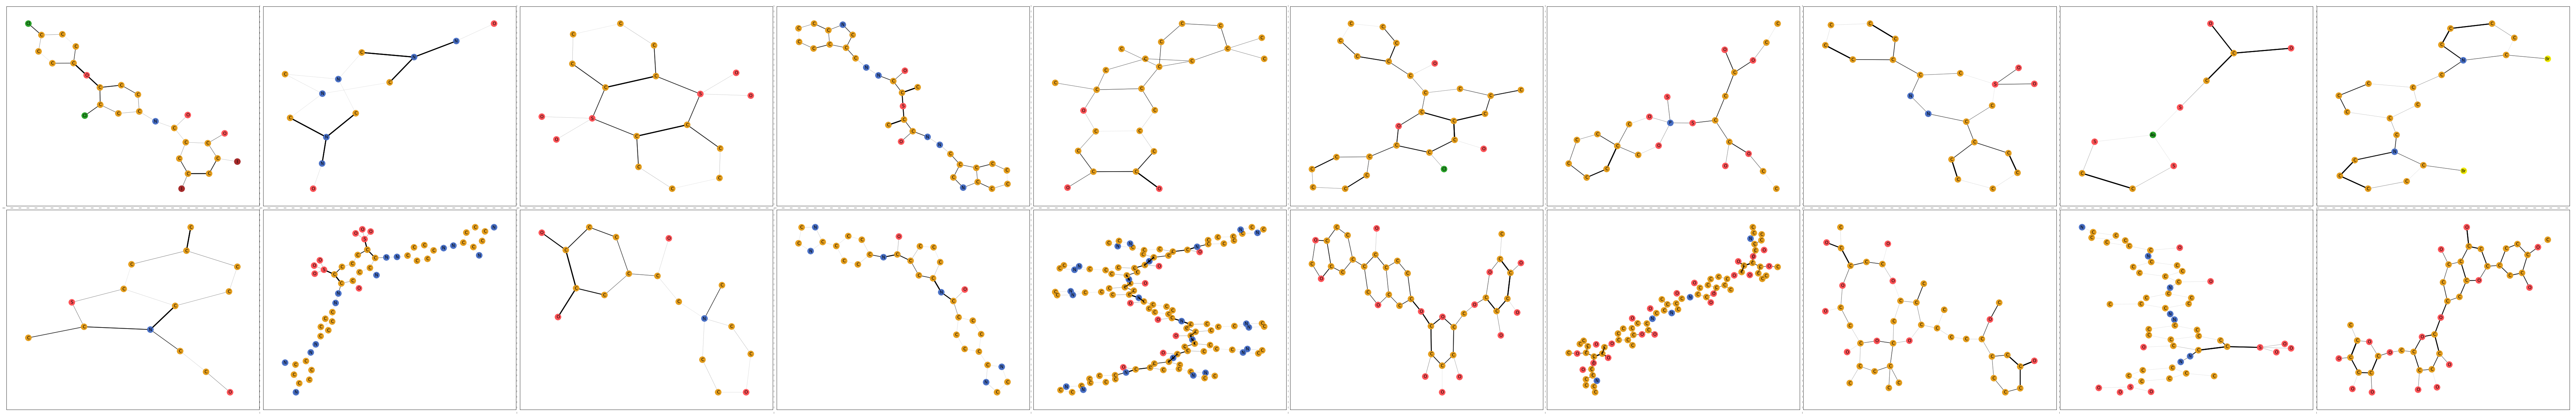

In [8]:
num_viz_samples = 10
assert aux_info['multi_label'] is False

all_viz_set = get_viz_idx(test_set, dataset_name, num_viz_samples)
visualize_results(gsat, all_viz_set, test_set, num_viz_samples, dataset_name, model_config['use_edge_attr'])